# Mentos
Mentos is a strategy that heavily relies on momentum. It enriches dataframe with simple momentum and industrial momentum factors. Returns will be substracted by a cross-sectional median.

In [1]:
from functools import reduce
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import warnings
warnings.filterwarnings('ignore')

In [2]:
# select stocks with market cap > 100 million, trading price > 5 as stock universe
raw = pd.read_parquet("../data/train-beta.1.parquet")
gvkeys = raw[(raw.mcap > 1e8) & (raw.prccd > 5)].index.get_level_values("gvkey").unique()
df = raw.loc[gvkeys]

In [3]:
def conf(clf, X_test, y_test):
    f, ax = plt.subplots(figsize=(4.8, 4.8))
    y_test_pred = clf.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    conf_ax = sns.heatmap(
        conf_mat, ax=ax, annot=True, fmt="", cmap=plt.cm.Blues, cbar=False
    )
    conf_ax.set_xlabel("Predicted")
    conf_ax.set_ylabel("True")

In [4]:
def extreme(df):
    """Retain the 20% values that are the smallest and the 20% that are the largest."""
    top = df.y.quantile(0.8)
    low = df.y.quantile(0.2)
    return df[(df.y < low) | (df.y > top)]

In [5]:
def mentos(df):
    """
    Mentos is a strategy that heavily relies on momentum.
    It enriches dataframe with simple momentum and industrial momentum factors. 
    Returns will be substracted by a cross-sectional median.
    """
    df_mom = df[["sic",
                 "mcap",
                 "act",
                 "ceq",
                 "cogs",
                 "lct",
                 "nicon",
                 "revt",
                 "xrd",
                 "prccd",
                 "close"]]
    df_mom.fillna({"mcap":0, "act":0, "ceq":0, "cogs":0, "lct":0, "nicon":0, "revt":0, "xrd":0}, inplace=True)
    df_mom["profitability_roe"]=df_mom.nicon / df_mom.ceq
    df_mom["intangible_rdm"] = df_mom.xrd / df_mom.mcap
    df_mom["liquid_cur"] = df_mom.act / df_mom.lct
    df_mom["market_pe"] = df_mom.mcap / (df_mom.nicon * 10 ** 6)
    df_mom["market_mb"] = df_mom.mcap / (df_mom.ceq * 10 ** 6)
    df_mom["52wk_high"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x) - np.log(x.rolling(12, min_periods=1).max()))
    df_mom["mom_12m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x.shift(2))-np.log(x.shift(13)))
    df_mom["mom_6m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x).shift(2)-np.log(x.shift(7)))
    df_mom["mom_1m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x)-np.log(x.shift(1)))
    df_mom["ind_mom_12m"] = df_mom.groupby(["date", "sic"]).mom_12m.transform("mean")
    df_mom["ind_mom_6m"] = df_mom.groupby(["date", "sic"]).mom_6m.transform("mean")
    df_mom["ind_mom_1m"] = df_mom.groupby(["date", "sic"]).mom_1m.transform("mean")
    df_mom["log_return"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x.shift(-3)) - np.log(x))
    df_mom["y"] = df_mom.groupby("date").log_return.transform(lambda x: (x - x.median()).clip(-1,1))
    return df_mom.loc[df.prccd > 5, ["mcap",
                                     "profitability_roe",
                                     "intangible_rdm",
                                     "liquid_cur",
                                     "market_mb",
                                     "market_pe",
                                     "52wk_high",
                                     "mom_12m",
                                     "mom_6m",
                                     "mom_1m",
                                     "ind_mom_12m",
                                     "ind_mom_6m",
                                     "ind_mom_1m",
                                     "y"]].dropna()

In [6]:
df_mom = mentos(df)

## Regression

In [7]:
def r2(y_true, y_pred):
    r2 = 1 - np.sum((y_true - y_pred) ** 2)/np.sum(y_true ** 2)
    return r2

r2_score = make_scorer(r2)

In [8]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train = df_train["y"].to_numpy()
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test = df_test["y"].to_numpy()

In [9]:
xgb_reg = XGBRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
xgb_fit = xgb_reg.fit(X_train, y_train)
train_score = r2_score(xgb_reg, X_train, y_train)
test_score = r2_score(xgb_reg, X_test, y_test)
print(f"R2 on training set: {train_score}\nR2 on test set: {test_score}")

R2 on training set: 0.11239818272197344
R2 on test set: 0.008236839395224571


## Binary Classification

In [10]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train = np.where(df_train.y > 0, 0, 1)
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test = np.where(df_test.y > 0, 0, 1)

Accuracy on training set: 0.5964019192652203
Accuracy on test set: 0.5447107837217727
              precision    recall  f1-score   support

        sell       0.55      0.65      0.60     17258
         buy       0.53      0.43      0.47     15866

    accuracy                           0.54     33124
   macro avg       0.54      0.54      0.54     33124
weighted avg       0.54      0.54      0.54     33124



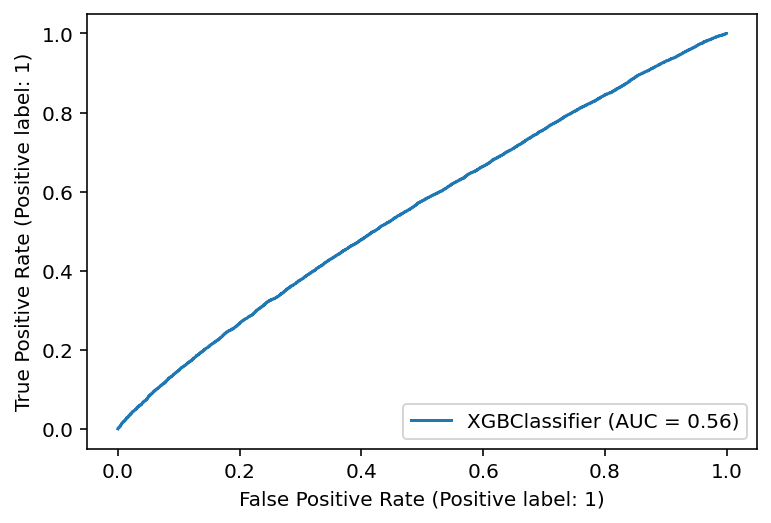

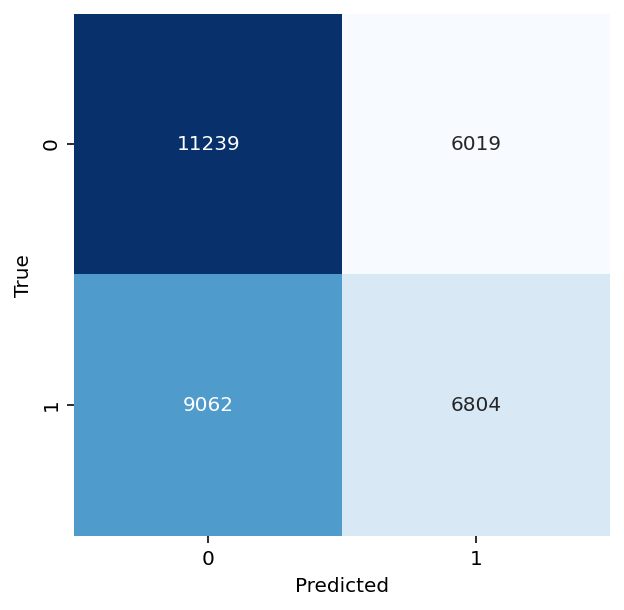

In [11]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric='logloss', n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred)
plot_roc_curve(xgb_clf, X_test, y_test)
conf(xgb_clf, X_test, y_test)
print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
print(classification_report(y_test, y_pred, target_names=["sell", "buy"]))

## Multi Classification

In [12]:
def threshold(y):
    thres = 0.1
    y_0 = np.where(y < -thres, -1, y)
    y_1 = np.where((y <= thres) & (y >= -thres), 0, y_0)
    y_2 = np.where(y > thres, 1, y_1)
    return y_2

In [13]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False).groupby("date").apply(extreme)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train= threshold(df_train.y)
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test= threshold(df_test.y)

Accuracy on training set: 0.6033909304778129
Accuracy on test set: 0.2155234875015095
              precision    recall  f1-score   support

        sell       0.22      0.46      0.29      5709
        hold       0.50      0.00      0.00     20897
         buy       0.21      0.69      0.33      6518

    accuracy                           0.22     33124
   macro avg       0.31      0.38      0.21     33124
weighted avg       0.40      0.22      0.12     33124



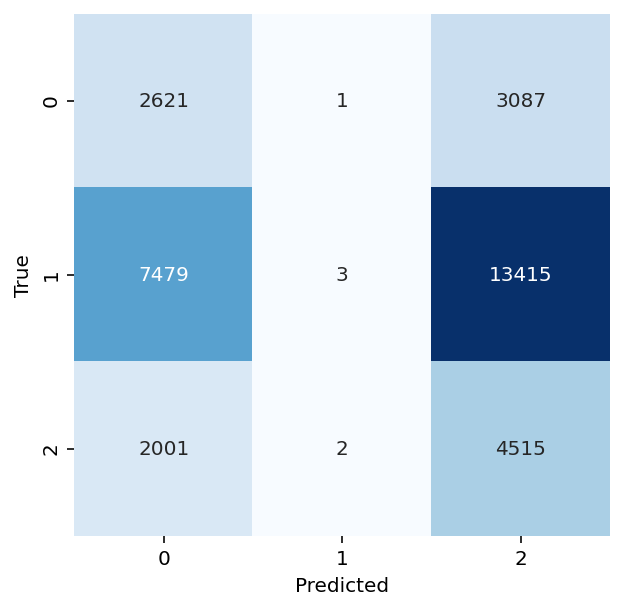

In [14]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric='logloss', n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred= xgb_clf.predict(X_test)
train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred)
conf(xgb_clf, X_test, y_test)
print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
print(classification_report(y_test, y_pred, target_names=["sell", "hold", "buy"]))

<AxesSubplot:>

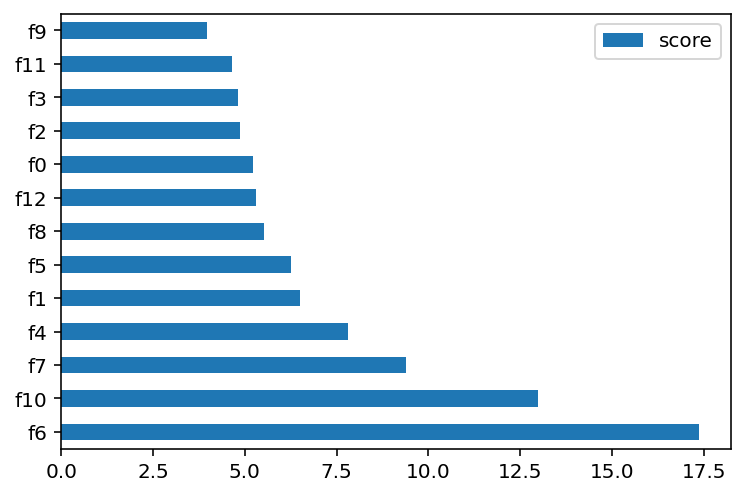

In [15]:
feature_important = xgb_clf.get_booster().get_score(importance_type="gain")
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=False)
data.plot(kind='barh')

## Portfolio Return

In [16]:
df_train = df_mom.xs(slice("2002-01-01", "2010-01-01"), level="date", drop_level=False).groupby("date").apply(extreme)
df_test = df_mom.xs(slice("2010-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train= threshold(df_train.y)
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test = threshold(df_test.y)
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric='logloss', n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred= xgb_clf.predict(X_test)
train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred)
print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
print(classification_report(y_test, y_pred, target_names=["sell", "hold", "buy"]))

Accuracy on training set: 0.618374198799471
Accuracy on test set: 0.2188144976178076
              precision    recall  f1-score   support

        sell       0.22      0.44      0.29      8883
        hold       0.80      0.00      0.00     32271
         buy       0.22      0.69      0.33     10689

    accuracy                           0.22     51843
   macro avg       0.41      0.38      0.21     51843
weighted avg       0.58      0.22      0.12     51843



In [17]:
def frame_to_signals(frame, estimator):
    X = frame.drop(columns="y").to_numpy()
    short_array = -1 * estimator.predict_proba(X)[:, 0]
    long_array = estimator.predict_proba(X)[:, -1]
    short_signal = pd.Series(short_array, frame.index)
    long_signal = pd.Series(long_array, frame.index)
    return short_signal, long_signal

In [18]:
def noise_to_belief(signal, n):
    return signal.groupby("date", group_keys=False).apply(lambda x: x.sort_values(ascending=False, key=abs).head(n))

In [19]:
def monthly_to_daily(signal, months, weight):
    daily_signals = []
    for index, value in signal.iteritems():
        gvkey = index[0]
        predict_date = pd.to_datetime(index[1])
        start = predict_date + DateOffset(days=1)
        end = predict_date + DateOffset(months=months)
        date_range = pd.date_range(start, end, freq="D", name="date")
        daily_idx = pd.MultiIndex.from_tuples([(gvkey, date) for date in date_range], names=["gvkey", "date"])
        if weight == "equal":
            daily_signal = pd.Series(np.sign(value), daily_idx)
        elif weight == "value":
            daily_signal = pd.Series(value, daily_idx)
        daily_signals.append(daily_signal)
    return pd.concat(daily_signals)

In [20]:
def signals_to_positions(short_signal, long_signal, n=10, months=3, weight="equal"):
    short_belief = noise_to_belief(short_signal, n)
    long_belief = noise_to_belief(long_signal, n)
    short_daily = monthly_to_daily(short_belief, months, weight)
    long_daily = monthly_to_daily(long_belief, months, weight)
    short_position = short_daily.groupby(["gvkey", "date"]).agg("sum")
    long_position = long_daily.groupby(["gvkey", "date"]).agg("sum")
    neutral_position = pd.concat([short_position, long_position]).groupby(["gvkey", "date"]).agg("sum")
    return short_position, long_position, neutral_position

In [21]:
def position_to_margin(data, position, tx=-0.001, method="log"):
    merged = pd.merge(position.rename("position"), data.close, how="left", left_index=True, right_index=True)
    merged["close"] = merged.close.groupby("gvkey").fillna(method="ffill")
    merged["tx"] = np.where(position.shift(1) != position, tx, 0)
    if method == "log":
        merged["margin"] = merged.close.groupby("gvkey").transform(lambda x: np.log(x / x.shift(1))).fillna(0)
        margin = merged.position * merged.margin + merged.tx
        margin = margin.droplevel("gvkey").resample("D").mean().cumsum()
    elif method == "percent":
        merged["margin"] = merged.close.groupby("gvkey").transform(lambda x: x.pct_change(1)).fillna(0)
        margin = merged.position * merged.margin + merged.tx
        margin = 1 + margin.droplevel("gvkey").resample("D").mean().cumsum()
    return margin

In [22]:
def sharpe_ratio(data, position):
    merged = pd.merge(position.rename("position"), data.close, how="left", left_index=True, right_index=True)
    merged["close"] = merged.close.groupby("gvkey").fillna(method="ffill")
    merged["tx"] = np.where(position.shift(1) != position, -0.001, 0)
    merged["margin"] = merged.close.groupby("gvkey").transform(lambda x: x.pct_change(1)).fillna(0)
    margin = merged.position * merged.margin + merged.tx
    margin = margin.droplevel("gvkey").resample("D").mean()
    return margin.mean() / margin.std() * np.sqrt(252)

In [23]:
data = pd.read_parquet("../data/backtest-beta.1.parquet")
short_signal, long_signal = frame_to_signals(df_test, xgb_clf)
short_position, long_position, neutral_position = signals_to_positions(short_signal, long_signal, n=10, months=3, weight="equal")

Sharpe ratio: 0.21432036046059552


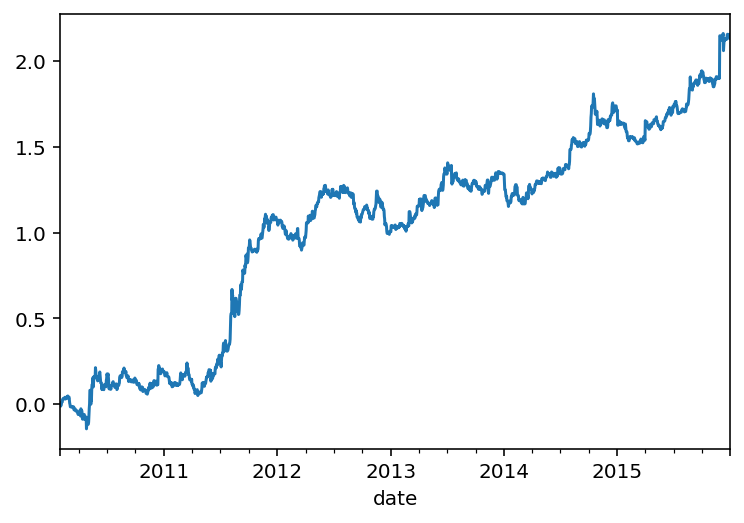

In [24]:
margin = position_to_margin(data, short_position, method="log")
margin.plot()
sharpe = sharpe_ratio(data, short_position)
print(f"Sharpe ratio: {sharpe}")

Sharpe ratio: 2.1356145574590535


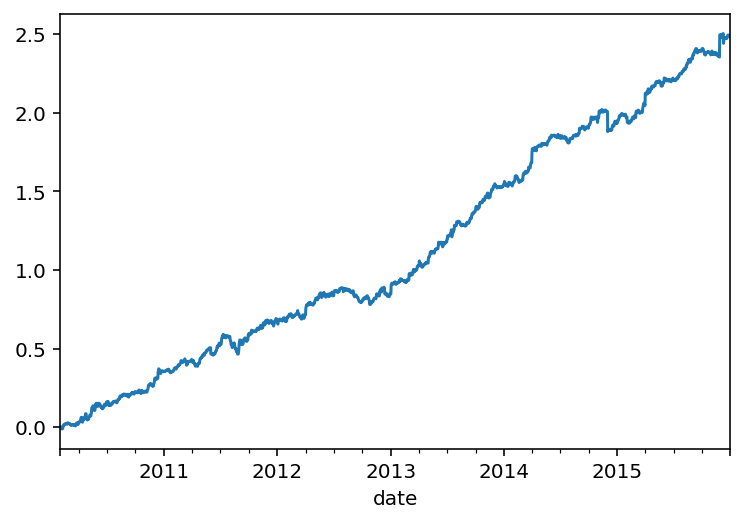

In [25]:
margin = position_to_margin(data, neutral_position, method="log")
margin.plot()
sharpe = sharpe_ratio(data, neutral_position)
print(f"Sharpe ratio: {sharpe}")

Sharpe ratio: 2.001463873836113


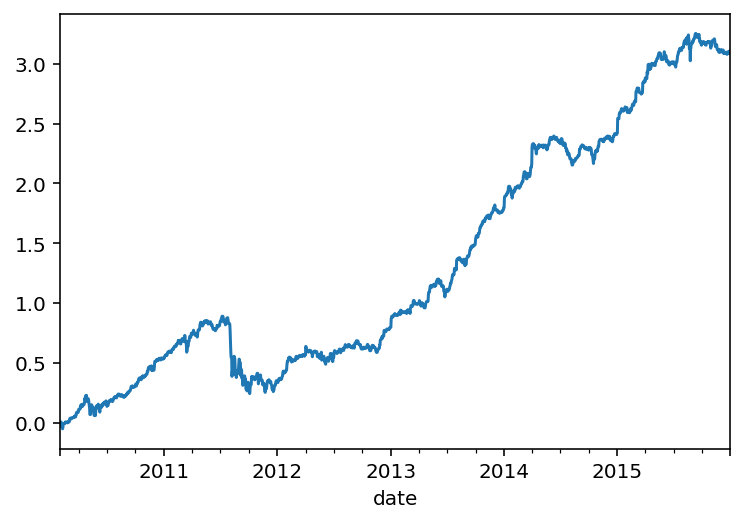

In [26]:
margin = position_to_margin(data, long_position, method="log")
margin.plot()
sharpe = sharpe_ratio(data, long_position)
print(f"Sharpe ratio: {sharpe}")